<a href="https://colab.research.google.com/github/Mohammed-Hatem/mnist-linear-and-deep/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning — Assignment 2

##  Team Members
- **Mohammed Hatem**
- **Ahmed Ayman**
- **Joseph Yousery**

# Part A: Linear Classification Models

## A1. Data Preparation

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

torch.manual_seed(42)

# Load and normalize MNIST data
transform = transforms.ToTensor()
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_full = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Combine all images and labels
all_images = torch.cat([img for img, _ in full_train_dataset] + [img for img, _ in test_dataset_full])
all_labels = torch.cat([torch.tensor([label]) for _, label in full_train_dataset] +
                       [torch.tensor([label]) for _, label in test_dataset_full])

# Flatten images to 784 features
X_flat = all_images.contiguous().view(-1, 28 * 28)

# Split data into train/val/test (60/20/20)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_flat.numpy(), all_labels.numpy(), test_size=0.4, random_state=42, stratify=all_labels.numpy()
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp
)

# Convert to tensors
X_train, Y_train = torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).long()
X_val, Y_val = torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).long()
X_test, Y_test = torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).long()

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.1MB/s]


### Helper Functions
These utility functions calculate accuracy, plot metrics, and visualize confusion matrices.

In [ ]:

def calculate_accuracy(model, data_loader, binary_task=False, target_classes=None):
    total_correct, total_samples = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            if binary_task:
                mask = (targets == target_classes[0]) | (targets == target_classes[1])
                inputs, targets = inputs[mask], targets[mask]
                targets_binary = (targets == target_classes[1]).float()
                outputs = model(inputs.view(-1, 784))
                preds = (outputs.squeeze() >= 0.5).float()
                total_correct += (preds == targets_binary).sum().item()
                total_samples += targets.size(0)
            else:
                outputs = model(inputs.view(-1, 784))
                _, preds = torch.max(outputs, 1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
    return (total_correct / total_samples) * 100 if total_samples > 0 else 0

def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metrics, label=f'Train {metric_name}')
    plt.plot(val_metrics, label=f'Val {metric_name}')
    plt.title(f'{metric_name} Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

def get_confusion_matrix(model, X_data, Y_data, binary_task=False, target_classes=None):
    model.eval()
    with torch.no_grad():
        if binary_task:
            mask = (Y_data == target_classes[0]) | (Y_data == target_classes[1])
            X_data, Y_data = X_data[mask], Y_data[mask]
            Y_data = (Y_data == target_classes[1]).long()
            outputs = model(X_data.view(-1, 784))
            preds = (outputs.squeeze() >= 0.5).long()
            class_names = [str(c) for c in target_classes]
        else:
            outputs = model(X_data.view(-1, 784))
            _, preds = torch.max(outputs, 1)
            class_names = [str(i) for i in range(10)]
    cm = confusion_matrix(Y_data.cpu().numpy(), preds.cpu().numpy())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return cm


## A2. Logistic Regression Implementation

Epoch 10/50: TrainLoss=0.0086, ValLoss=0.0077, ValAcc=99.86%
Epoch 20/50: TrainLoss=0.0058, ValLoss=0.0058, ValAcc=99.86%
Epoch 30/50: TrainLoss=0.0048, ValLoss=0.0049, ValAcc=99.86%
Epoch 40/50: TrainLoss=0.0045, ValLoss=0.0044, ValAcc=99.86%
Epoch 50/50: TrainLoss=0.0038, ValLoss=0.0041, ValAcc=99.86%

--- A2. Binary Logistic Regression (0 vs 1) ---


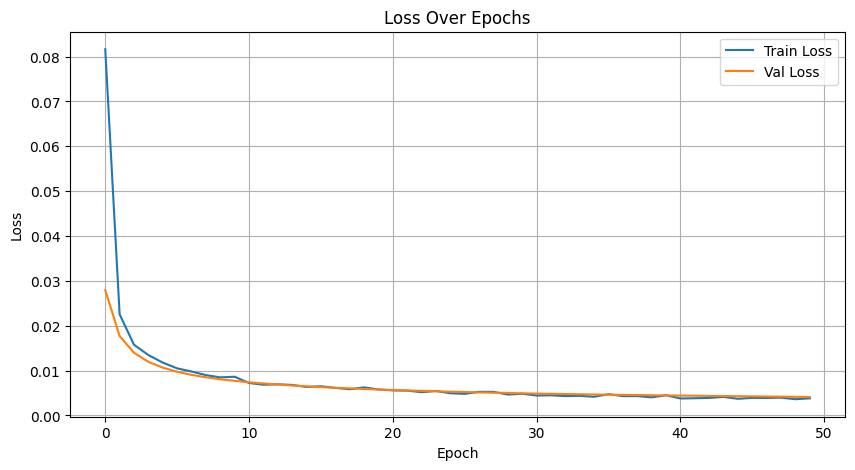

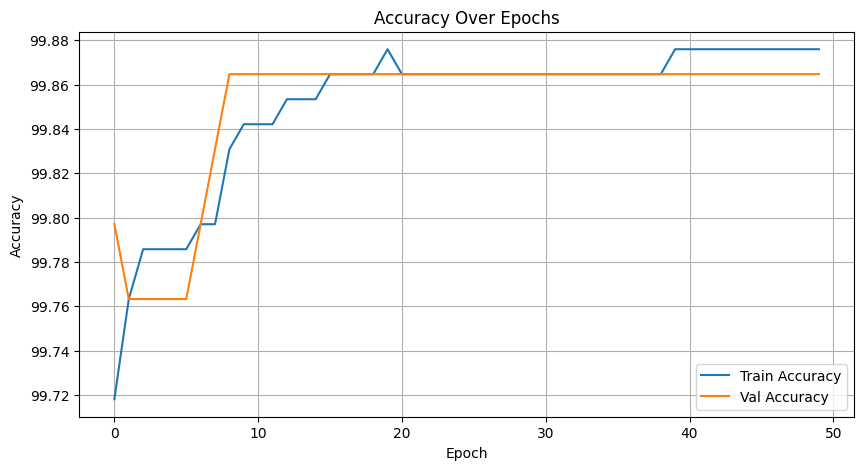

Final Test Accuracy (0 vs 1): 99.86%


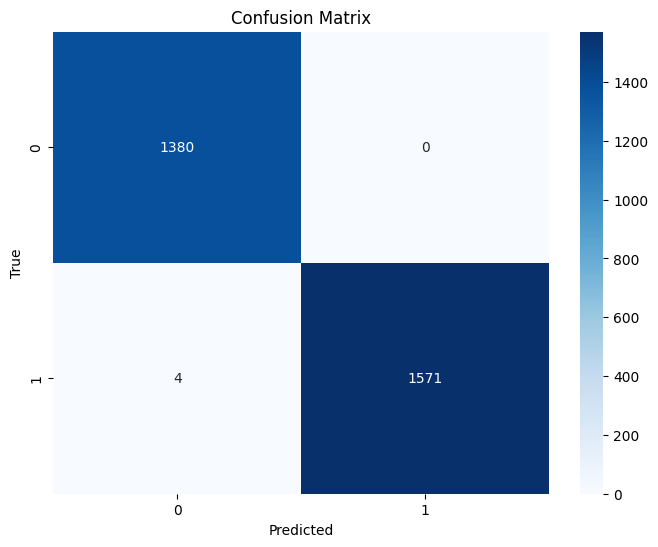

array([[1380,    0],
       [   4, 1571]])

In [ ]:

class LogisticRegressionFromScratch(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionFromScratch, self).__init__()
        self.W = nn.Parameter(torch.randn(input_size, 1) * 0.01)
        self.b = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        return torch.sigmoid(torch.matmul(x, self.W) + self.b)

def binary_cross_entropy_loss(y_hat, y):
    y = y.float().view(y_hat.shape)
    eps = 1e-7
    return -torch.mean(y * torch.log(y_hat + eps) + (1 - y) * torch.log(1 - y_hat + eps))

def train_logistic_regression(model, train_loader, val_loader, target_classes, lr=0.01, epochs=50, X_val=None, Y_val=None):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    mask_val = (Y_val == target_classes[0]) | (Y_val == target_classes[1])
    X_val_f, Y_val_f = X_val[mask_val], Y_val[mask_val]
    val_bin = (Y_val_f == target_classes[1]).float()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            mask = (y == target_classes[0]) | (y == target_classes[1])
            X, y = X[mask], y[mask]
            if X.size(0) == 0:
                continue
            y_bin = (y == target_classes[1]).float()
            out = model(X.view(-1, 784))
            loss = binary_cross_entropy_loss(out, y_bin)
            total_loss += loss.item()
            loss.backward()
            with torch.no_grad():
                model.W -= lr * model.W.grad
                model.b -= lr * model.b.grad
            model.zero_grad()
        train_losses.append(total_loss / len(train_loader))
        with torch.no_grad():
            val_loss = binary_cross_entropy_loss(model(X_val_f.view(-1, 784)), val_bin)
        val_losses.append(val_loss.item())
        train_accs.append(calculate_accuracy(model, train_loader, True, target_classes))
        val_accs.append(calculate_accuracy(model, val_loader, True, target_classes))
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}: TrainLoss={train_losses[-1]:.4f}, ValLoss={val_losses[-1]:.4f}, ValAcc={val_accs[-1]:.2f}%')
    return train_losses, val_losses, train_accs, val_accs

# Execute Logistic Regression
INPUT_SIZE = 784
LR_CLASSES = [0, 1]
lr_model = LogisticRegressionFromScratch(INPUT_SIZE)
lr_train_l, lr_val_l, lr_train_a, lr_val_a = train_logistic_regression(lr_model, train_loader, val_loader, LR_CLASSES, 0.01, 50, X_val, Y_val)
print("\n--- A2. Binary Logistic Regression (0 vs 1) ---")
plot_metrics(lr_train_l, lr_val_l, 'Loss')
plot_metrics(lr_train_a, lr_val_a, 'Accuracy')
lr_test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=BATCH_SIZE, shuffle=False)
test_acc_lr = calculate_accuracy(lr_model, lr_test_loader, True, LR_CLASSES)
print(f"Final Test Accuracy (0 vs 1): {test_acc_lr:.2f}%")
mask_test = (Y_test == LR_CLASSES[0]) | (Y_test == LR_CLASSES[1])
get_confusion_matrix(lr_model, X_test[mask_test], Y_test[mask_test], True, LR_CLASSES)


## A3. Softmax Regression Implementation

Epoch 10/50: TrainLoss=0.3721, ValLoss=0.3778, ValAcc=89.75%
Epoch 20/50: TrainLoss=0.3294, ValLoss=0.3404, ValAcc=90.41%
Epoch 30/50: TrainLoss=0.3098, ValLoss=0.3250, ValAcc=90.85%
Epoch 40/50: TrainLoss=0.2988, ValLoss=0.3157, ValAcc=91.04%
Epoch 50/50: TrainLoss=0.2909, ValLoss=0.3098, ValAcc=91.26%

--- A3. Softmax Regression (Multi-class) ---


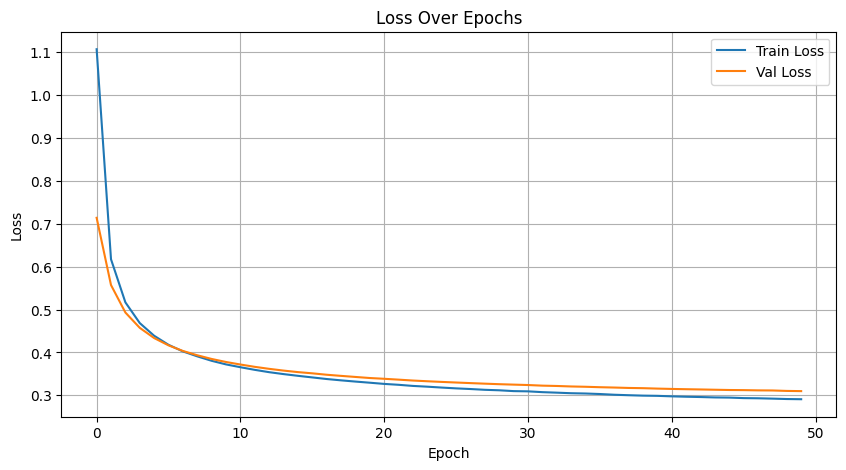

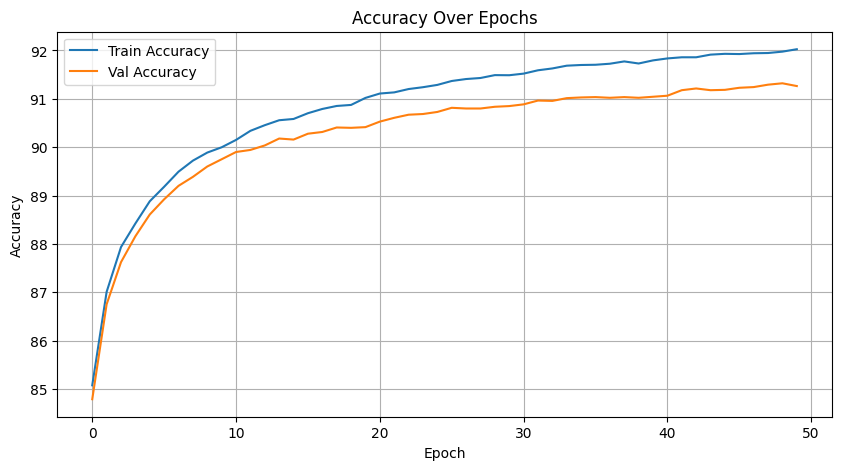

Final Test Accuracy (10 classes): 91.31%


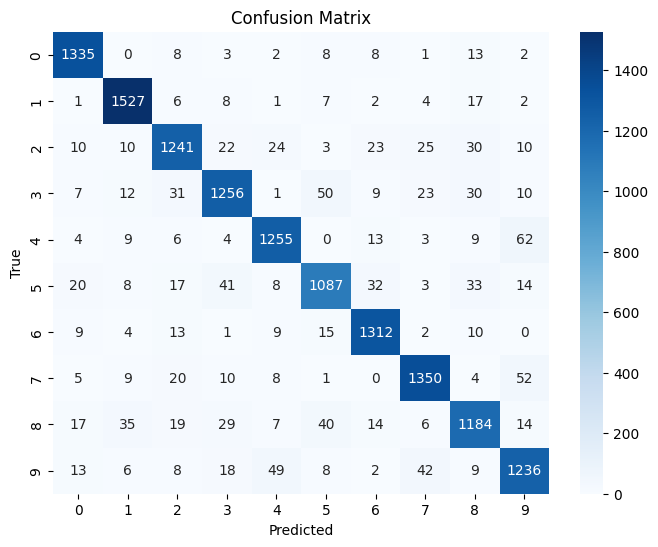

   Class  Accuracy (%)
0      0         96.74
1      1         96.95
2      2         88.77
3      3         87.89
4      4         91.94
5      5         86.06
6      6         95.42
7      7         92.53
8      8         86.74
9      9         88.86


In [ ]:

class SoftmaxRegressionFromScratch(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegressionFromScratch, self).__init__()
        self.W = nn.Parameter(torch.randn(input_size, num_classes) * 0.01)
        self.b = nn.Parameter(torch.zeros(num_classes))
    def forward(self, x):
        return torch.matmul(x, self.W) + self.b

def train_softmax_regression(model, train_loader, val_loader, lr=0.01, epochs=50):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    X_val_f = X_val.view(-1, 784)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X = X.view(-1, 784)
            logits = model(X)
            loss = F.cross_entropy(logits, y.long())
            total_loss += loss.item()
            loss.backward()
            with torch.no_grad():
                model.W -= lr * model.W.grad
                model.b -= lr * model.b.grad
            model.zero_grad()
        train_losses.append(total_loss / len(train_loader))
        with torch.no_grad():
            val_loss = F.cross_entropy(model(X_val_f), Y_val.long())
        val_losses.append(val_loss.item())
        train_accs.append(calculate_accuracy(model, train_loader))
        val_accs.append(calculate_accuracy(model, val_loader))
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}: TrainLoss={train_losses[-1]:.4f}, ValLoss={val_losses[-1]:.4f}, ValAcc={val_accs[-1]:.2f}%')
    return train_losses, val_losses, train_accs, val_accs

# Execute Softmax Regression
sm_model = SoftmaxRegressionFromScratch(INPUT_SIZE, 10)
sm_train_l, sm_val_l, sm_train_a, sm_val_a = train_softmax_regression(sm_model, train_loader, val_loader, 0.01, 50)
print("\n--- A3. Softmax Regression (Multi-class) ---")
plot_metrics(sm_train_l, sm_val_l, 'Loss')
plot_metrics(sm_train_a, sm_val_a, 'Accuracy')
test_acc_sm = calculate_accuracy(sm_model, test_loader)
print(f"Final Test Accuracy (10 classes): {test_acc_sm:.2f}%")
sm_cm = get_confusion_matrix(sm_model, X_test, Y_test)
cm_norm = sm_cm.astype('float') / sm_cm.sum(axis=1)[:, np.newaxis]
per_class_acc = cm_norm.diagonal() * 100
print(pd.DataFrame({'Class': [i for i in range(10)], 'Accuracy (%)': per_class_acc.round(2)}))


In [ ]:
# PyTorch Built-in Softmax Regression for verification
import torch, torch.nn as nn, torch.nn.functional as F, time

torch.manual_seed(0)

# Simple linear classifier
builtin_model = nn.Linear(784, 10)
nn.init.xavier_uniform_(builtin_model.weight)
optimizer = torch.optim.SGD(builtin_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

EPOCHS = 30
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    builtin_model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb = Xb.view(-1, 784)
        optimizer.zero_grad()
        logits = builtin_model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # validation
    builtin_model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.view(-1, 784)
            logits = builtin_model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    val_losses.append(val_loss / len(val_loader))
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: train loss={train_losses[-1]:.4f}, val loss={val_losses[-1]:.4f}, val acc={100*correct/total:.2f}%")

# === Evaluate on test set ===
builtin_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.view(-1, 784)
        preds = builtin_model(Xb).argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
builtin_test_acc = 100 * correct / total
print(f"\nBuiltin Softmax Regression Test Accuracy: {builtin_test_acc:.2f}%")


Epoch 10: train loss=0.3748, val loss=0.3790, val acc=89.64%
Epoch 20: train loss=0.3304, val loss=0.3411, val acc=90.42%
Epoch 30: train loss=0.3111, val loss=0.3250, val acc=90.94%

Builtin Softmax Regression Test Accuracy: 90.89%


# Neural Network

# Data Preperation

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

tran = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data_full = datasets.MNIST(root='./data', train=True, download=True, transform=tran)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=tran)

#split the train into 75% train 25% validation
train_size = int(0.75 * len(train_data_full))
val_size = len(train_data_full) - train_size
train_data, val_data = random_split(train_data_full, [train_size, val_size])


loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(val_data, batch_size=64),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64)
}

print(train_data)

print("Train batches:", len(loaders['train']))
print("Validation batches:", len(loaders['val']))
print("Test batches:", len(loaders['test']))


Using device: cuda
Train batches: 704
Validation batches: 235
Test batches: 157


# B1 Model creation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Flexible MLP for Part B
# - Pass any list of hidden layer sizes via `hidden_layers` (e.g., [64, 128, 256])
# - Defaults preserve the original two-layer architecture [200, 50]
class Model(nn.Module):
  def __init__(self, inp_size=28*28, hidden_layers=None, classes=10, activation='relu'):
    super(Model, self).__init__()
    if hidden_layers is None:
      hidden_layers = [200, 50]
    self.inp_size = inp_size
    self.hidden_layers = list(hidden_layers)
    self.classes = classes
    self.activation = activation

    # Construct Linear layers according to hidden_layers
    self.fcs = nn.ModuleList()
    prev = inp_size
    for h in self.hidden_layers:
      fc = nn.Linear(prev, h)
      nn.init.xavier_uniform_(fc.weight)
      nn.init.zeros_(fc.bias)
      self.fcs.append(fc)
      prev = h

    # Output layer
    self.out = nn.Linear(prev, classes)
    nn.init.xavier_uniform_(self.out.weight)
    nn.init.zeros_(self.out.bias)

  def forward(self, x):
    x = x.view(x.size(0), -1)  # flatten to [B, 784]
    for fc in self.fcs:
      x = fc(x)
      if self.activation == 'relu':
        x = F.relu(x)
      elif self.activation == 'leaky_relu':
        x = F.leaky_relu(x, negative_slope=0.1)
      else:
        # default fallback
        x = F.relu(x)
    x = self.out(x)  # logits
    return x


# Instantiate with the default architecture (same as before)
model = Model()
print(model)


Model(
  (fcs): ModuleList(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=50, bias=True)
  )
  (out): Linear(in_features=50, out_features=10, bias=True)
)


# B2. Training Infrastructure

In [ ]:
import time
import numpy as np
import torch

epochs = 10
lr = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# accuracy helper
def accuracy(preds, labels):
    return (preds.argmax(1) == labels).float().mean()

# lists for visualization
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# for error bars
batch_accs_per_epoch = []
val_batch_accs_per_epoch = []

# early stopping
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = "best_model.pt"

# move model to device
model.to(device)

start_time = time.time()

for epoch in range(epochs):

    #training
    model.train()
    epoch_train_loss, epoch_train_acc = 0.0, 0.0
    batch_accs = []  # store batch accuracies for error bars

    for images, labels in loaders['train']:
        images, labels = images.to(device), labels.to(device)

        # forward
        logits = model(images)
        loss = criterion(logits, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics
        batch_accuracy = accuracy(logits, labels).item()
        batch_accs.append(batch_accuracy)
        epoch_train_loss += loss.item() * images.size(0)
        epoch_train_acc  += batch_accuracy * images.size(0)

    batch_accs_per_epoch.append(batch_accs)

    # validation
    model.eval()
    epoch_val_loss, epoch_val_acc = 0.0, 0.0
    val_batch_accs = []

    with torch.no_grad():
        for images, labels in loaders['val']:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            batch_accuracy = accuracy(logits, labels).item()
            val_batch_accs.append(batch_accuracy)
            epoch_val_loss += loss.item() * images.size(0)
            epoch_val_acc  += batch_accuracy * images.size(0)

    val_batch_accs_per_epoch.append(val_batch_accs)

    # normalize
    train_loss_epoch = epoch_train_loss / len(loaders['train'].dataset)
    val_loss_epoch   = epoch_val_loss   / len(loaders['val'].dataset)
    train_acc_epoch  = epoch_train_acc  / len(loaders['train'].dataset)
    val_acc_epoch    = epoch_val_acc    / len(loaders['val'].dataset)

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)
    train_accs.append(train_acc_epoch)
    val_accs.append(val_acc_epoch)


    print(f"Epoch {epoch+1:03d}/{epochs} | "
          f"Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | "
          f"Train Acc: {train_acc_epoch*100:.2f}% | Val Acc: {val_acc_epoch*100:.2f}%")

    #early stopping
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)  # save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTraining completed in {elapsed/60:.2f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")

# Load the best model weights (for evaluation later)
model.load_state_dict(torch.load(best_model_path))


Epoch 001/10 | Train Loss: 0.6290 | Val Loss: 0.4550 | Train Acc: 82.10% | Val Acc: 85.99%
Epoch 002/10 | Train Loss: 0.3295 | Val Loss: 0.3084 | Train Acc: 90.33% | Val Acc: 91.23%
Epoch 003/10 | Train Loss: 0.2793 | Val Loss: 0.6839 | Train Acc: 91.84% | Val Acc: 75.76%
Epoch 004/10 | Train Loss: 0.2496 | Val Loss: 0.2589 | Train Acc: 92.67% | Val Acc: 92.86%
Epoch 005/10 | Train Loss: 0.2250 | Val Loss: 0.2464 | Train Acc: 93.42% | Val Acc: 92.91%
Epoch 006/10 | Train Loss: 0.2050 | Val Loss: 0.2146 | Train Acc: 94.04% | Val Acc: 94.01%
Epoch 007/10 | Train Loss: 0.1883 | Val Loss: 0.2206 | Train Acc: 94.55% | Val Acc: 93.73%
Epoch 008/10 | Train Loss: 0.1732 | Val Loss: 0.2203 | Train Acc: 94.99% | Val Acc: 93.72%
Epoch 009/10 | Train Loss: 0.1611 | Val Loss: 0.1799 | Train Acc: 95.41% | Val Acc: 94.83%
Epoch 010/10 | Train Loss: 0.1493 | Val Loss: 0.1706 | Train Acc: 95.70% | Val Acc: 95.16%

Training completed in 2.04 minutes
Best validation loss: 0.1706


<All keys matched successfully>

#B3 Performance visualization

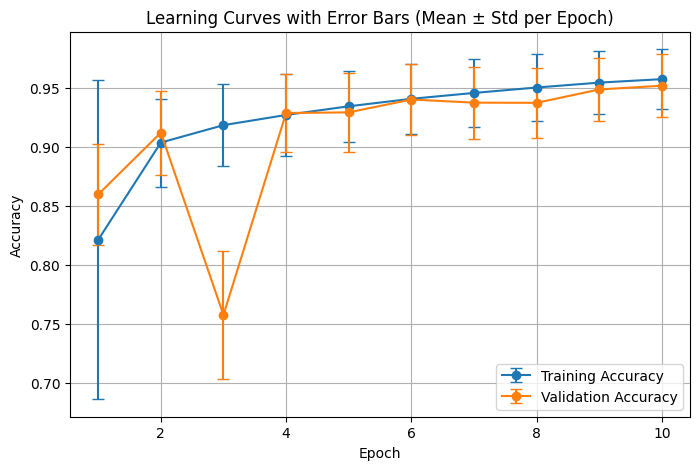

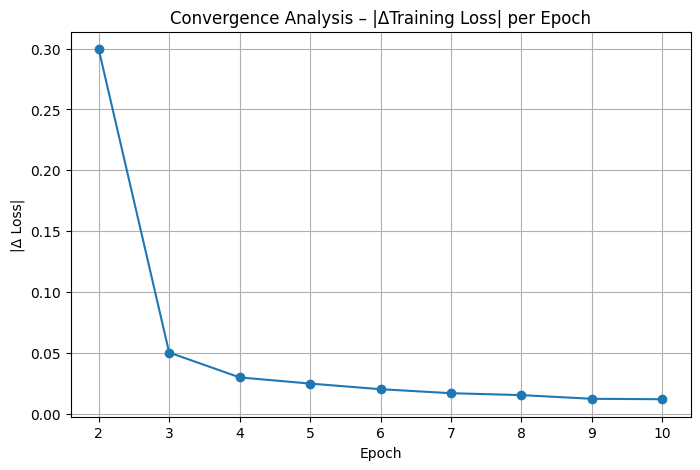

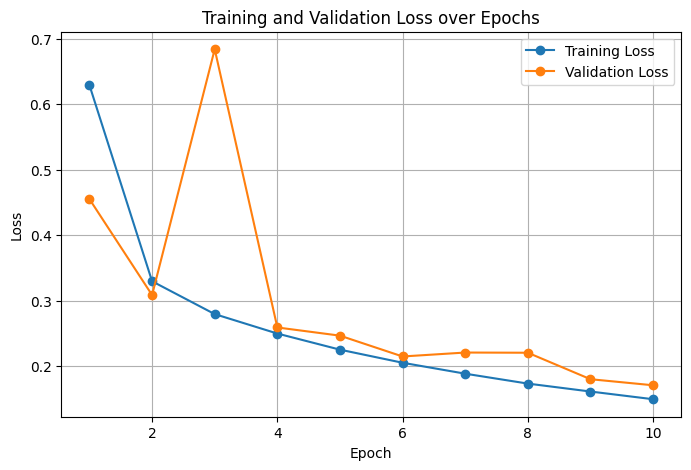

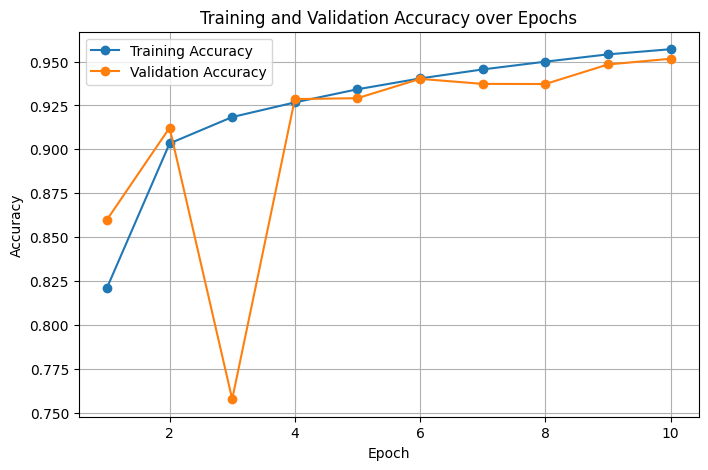

In [ ]:

import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

train_means = [np.mean(b) for b in batch_accs_per_epoch]
train_stds  = [np.std(b)  for b in batch_accs_per_epoch]
val_means   = [np.mean(b) for b in val_batch_accs_per_epoch]
val_stds    = [np.std(b)  for b in val_batch_accs_per_epoch]

plt.figure(figsize=(8,5))
plt.errorbar(epochs_range, train_means, yerr=train_stds, fmt='-o', capsize=4, label="Training Accuracy")
plt.errorbar(epochs_range, val_means,   yerr=val_stds,   fmt='-o', capsize=4, label="Validation Accuracy")
plt.title("Learning Curves with Error Bars (Mean ± Std per Epoch)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)
plt.show()


# Convergence Analysis
loss_diff = np.abs(np.diff(train_losses))
plt.figure(figsize=(8,5))
plt.plot(range(2, len(train_losses)+1), loss_diff, marker='o')
plt.title("Convergence Analysis – |ΔTraining Loss| per Epoch")
plt.xlabel("Epoch"); plt.ylabel("|Δ Loss|")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_losses, 'o-', label="Training Loss")
plt.plot(epochs_range, val_losses,   'o-', label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()

# Training & Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_accs, 'o-', label="Training Accuracy")
plt.plot(epochs_range, val_accs,   'o-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)
plt.show()


# Test evaluation

Test Accuracy: 95.31%
[[ 964    0    2    1    0    3    8    1    1    0]
 [   0 1119    2    3    1    1    4    2    3    0]
 [   6    2  982    4    9    3    7    5   12    2]
 [   0    1   11  956    0   12    2    9   13    6]
 [   1    0    4    0  949    1   11    1    2   13]
 [   8    2    2   17    3  839    9    1    7    4]
 [  11    4    2    1    5   11  921    0    3    0]
 [   0   10   24    6    7    1    1  964    0   15]
 [   4    1    7   16    9   11    6    5  910    5]
 [   7    6    2   12   35    9    0    8    3  927]]


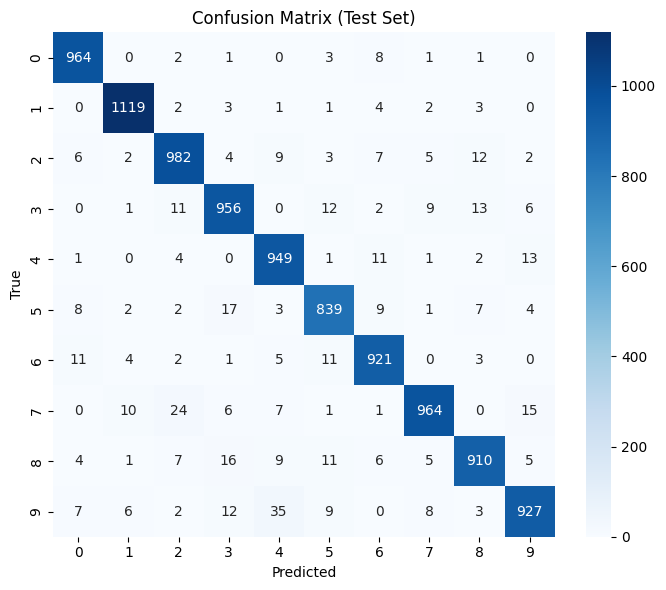

Per-Class Accuracy (%):
Class 0: 98.37%
Class 1: 98.59%
Class 2: 95.16%
Class 3: 94.65%
Class 4: 96.64%
Class 5: 94.06%
Class 6: 96.14%
Class 7: 93.77%
Class 8: 93.43%
Class 9: 91.87%


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in loaders['test']:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

acc = (all_preds == all_labels).float().mean().item()
print(f"Test Accuracy: {acc*100:.2f}%")

# Confusion matrix (numeric)
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# Confusion matrix heatmap
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

# Per-class accuracy
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
per_class_acc = (np.diag(cm_norm) * 100).round(2)
print("Per-Class Accuracy (%):")
for cls, p in enumerate(per_class_acc):
    print(f"Class {cls}: {p:.2f}%")


# Part C: Comprehensive Analysis

This section performs systematic experiments and comparisons as required:
- C1. Hyperparameter Analysis: learning rate, batch size, and architecture depth/width sweeps with plots and a comparison table.
- C2. Model Comparison: logistic regression vs softmax regression vs best neural network, with complexity and runtime discussion and a performance summary table.


## C1. Hyperparameter Analysis

We vary one parameter at a time while keeping others fixed (baseline: SGD, lr=0.01, batch size=64, epochs tuned for runtime):
- Learning Rate: [0.001, 0.01, 0.1, 1.0]
- Batch Size: [16, 32, 64, 128]
- Architecture: Hidden layers = [2, 3, 4, 5], Width per layer in [64, 128, 256, 512]

We plot learning curves, summarize results in tables, and briefly analyze convergence behavior and gradient noise.


In [ ]:
# Helpers for Part C sweeps (reuses Part B data and flexible Model)
import time
import math
import copy
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure device and datasets from Part B exist
try:
    device
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train_data, val_data, test_data are created in Part B (random_split on MNIST)

def get_loaders_bs(batch_size=64):
    return {
        'train': DataLoader(train_data, batch_size=batch_size, shuffle=True),
        'val':   DataLoader(val_data,   batch_size=batch_size, shuffle=False),
        'test':  DataLoader(test_data,  batch_size=batch_size, shuffle=False)
    }

# Training utility that records per-batch accuracy (for gradient noise proxy) and times
def train_mlp_sweep(hidden_layers, lr=0.01, batch_size=64, epochs=10, activation='relu', verbose=False):
    loaders_local = get_loaders_bs(batch_size)
    net = Model(hidden_layers=hidden_layers, activation=activation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    train_batch_acc_std_per_epoch = []
    t0 = time.time()

    for ep in range(epochs):
        # Train
        net.train()
        tl_sum, ta_sum, n_train = 0.0, 0.0, 0
        batch_accs = []
        for xb, yb in loaders_local['train']:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = net(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            bs = xb.size(0)
            tl_sum += loss.item() * bs
            acc_b = (logits.argmax(1) == yb).float().mean().item()
            batch_accs.append(acc_b)
            ta_sum += acc_b * bs
            n_train += bs
        train_losses.append(tl_sum / n_train)
        train_accs.append(ta_sum / n_train)
        train_batch_acc_std_per_epoch.append(float(np.std(batch_accs) if len(batch_accs) > 1 else 0.0))

        # Val
        net.eval()
        vl_sum, va_sum, n_val = 0.0, 0.0, 0
        with torch.no_grad():
            for xb, yb in loaders_local['val']:
                xb, yb = xb.to(device), yb.to(device)
                logits = net(xb)
                loss = criterion(logits, yb)
                bs = xb.size(0)
                vl_sum += loss.item() * bs
                va_sum += (logits.argmax(1) == yb).float().sum().item()
                n_val += bs
        val_losses.append(vl_sum / n_val)
        val_accs.append(va_sum / n_val)

        if verbose and ((ep+1) % 5 == 0 or ep == 0):
            print(f"Epoch {ep+1:02d}/{epochs} | TL={train_losses[-1]:.4f} VL={val_losses[-1]:.4f} TA={100*train_accs[-1]:.2f}% VA={100*val_accs[-1]:.2f}%")

    elapsed = time.time() - t0
    best_ep = int(np.argmax(val_accs))
    best_val_acc = float(val_accs[best_ep])
    # Return model if needed later
    return {
        'model': net,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'batch_acc_std': train_batch_acc_std_per_epoch,
        'best_val_acc': best_val_acc,
        'time_sec': elapsed,
        'batch_size': batch_size,
        'lr': lr,
        'hidden_layers': list(hidden_layers)
    }

# Plotting helpers

def plot_metric_over_sweep(histories, labels, key, title, ylabel):
    plt.figure(figsize=(9,5))
    for hist, lab in zip(histories, labels):
        plt.plot(hist[key], label=lab)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

# Utility

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


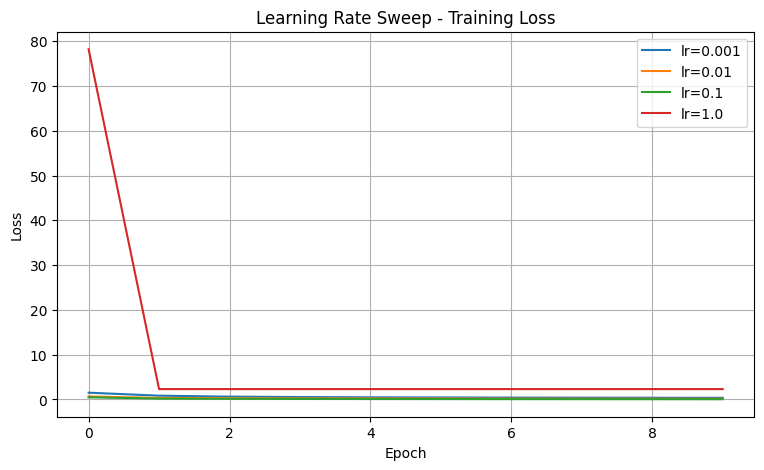

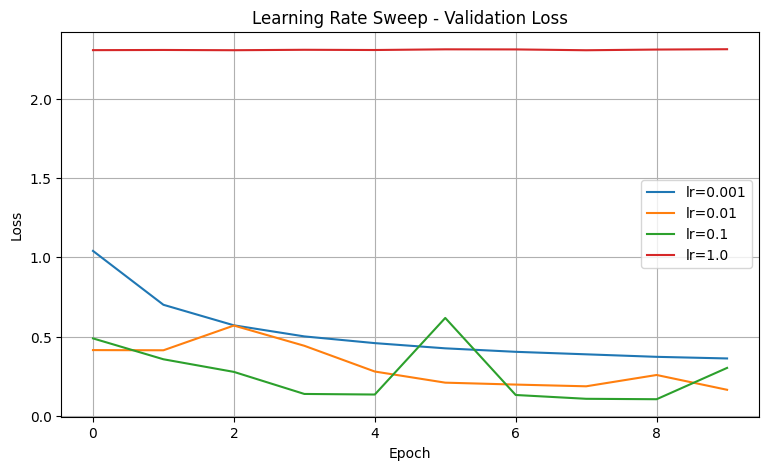

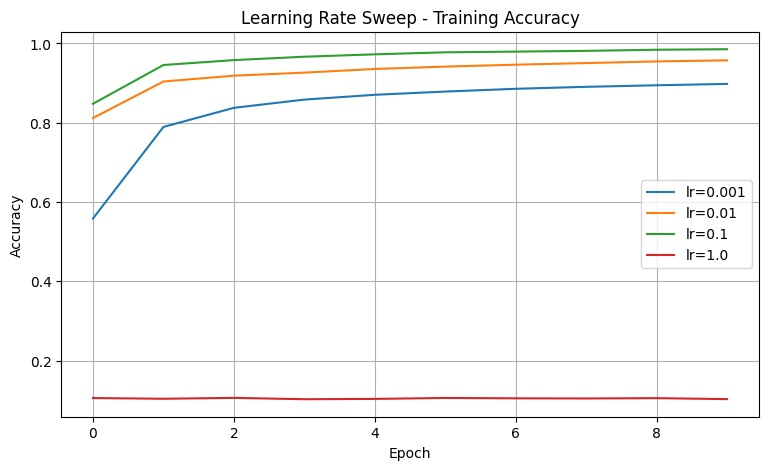

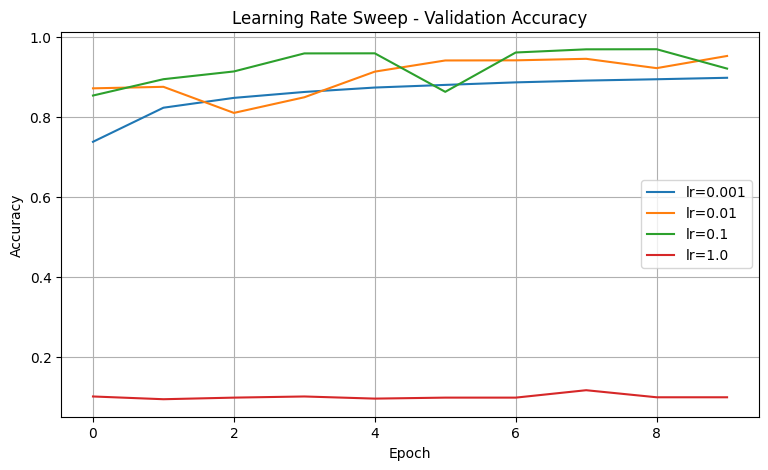

,lr,best_val_acc_%,time_sec
2,0.100,97.01,124.22
1,0.010,95.32,120.86
0,0.001,89.86,125.87
3,1.000,11.69,123.95


In [ ]:
# C1.a Learning Rate Sweep
EPOCHS_SWEEP = 10
BASE_BATCH_SIZE = 64
lrs = [0.001, 0.01, 0.1, 1.0]

lr_histories, lr_labels = [], []
for lr in lrs:
    h = train_mlp_sweep(hidden_layers=[200, 50], lr=lr, batch_size=BASE_BATCH_SIZE, epochs=EPOCHS_SWEEP)
    lr_histories.append(h)
    lr_labels.append(f"lr={lr}")

# Plots: loss and accuracy
plot_metric_over_sweep(lr_histories, lr_labels, 'train_losses', 'Learning Rate Sweep - Training Loss', 'Loss')
plot_metric_over_sweep(lr_histories, lr_labels, 'val_losses',   'Learning Rate Sweep - Validation Loss', 'Loss')
plot_metric_over_sweep(lr_histories, lr_labels, 'train_accs',   'Learning Rate Sweep - Training Accuracy', 'Accuracy')
plot_metric_over_sweep(lr_histories, lr_labels, 'val_accs',     'Learning Rate Sweep - Validation Accuracy', 'Accuracy')

# Summary table
lr_df = pd.DataFrame({
    'lr': lrs,
    'best_val_acc_%': [round(h['best_val_acc']*100, 2) for h in lr_histories],
    'time_sec': [round(h['time_sec'], 2) for h in lr_histories]
}).sort_values('best_val_acc_%', ascending=False)
lr_df


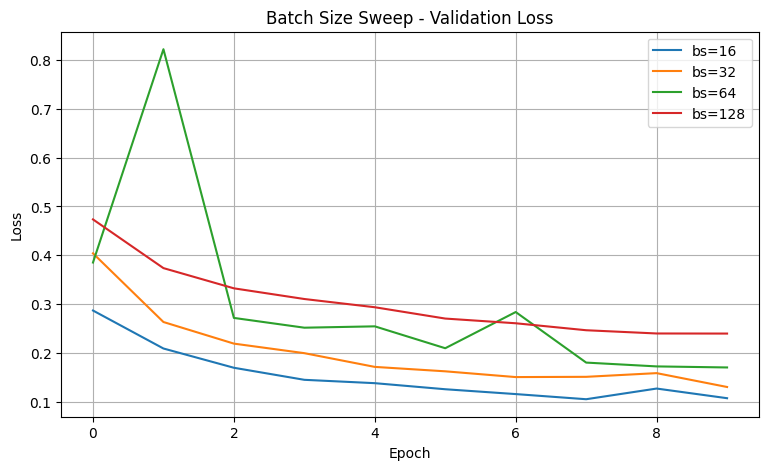

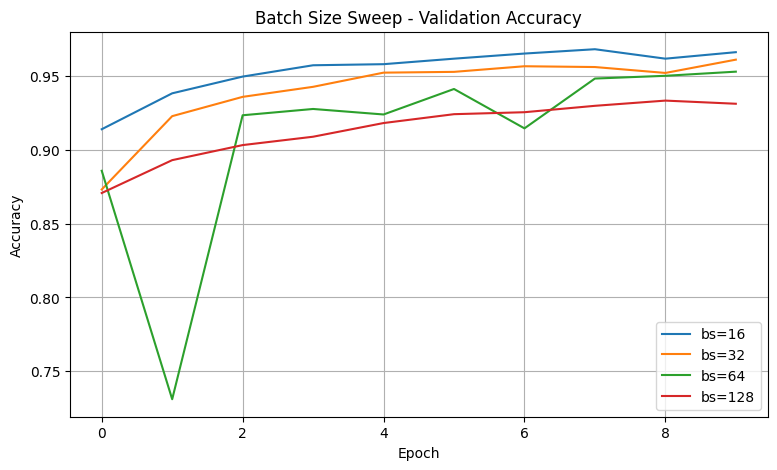

,batch_size,best_val_acc_%,avg_batch_acc_std,time_sec
0,16,96.81,0.0505,161.17
1,32,96.11,0.0445,134.92
2,64,95.29,0.0391,120.13
3,128,93.33,0.0373,114.18


In [ ]:
# C1.b Batch Size Sweep (gradient noise proxy via batch accuracy std)
EPOCHS_SWEEP = 10
LR_BASE = 0.01
batch_sizes = [16, 32, 64, 128]

bs_histories, bs_labels = [], []
for bs in batch_sizes:
    h = train_mlp_sweep(hidden_layers=[200, 50], lr=LR_BASE, batch_size=bs, epochs=EPOCHS_SWEEP)
    bs_histories.append(h)
    bs_labels.append(f"bs={bs}")

# Plots
plot_metric_over_sweep(bs_histories, bs_labels, 'val_losses', 'Batch Size Sweep - Validation Loss', 'Loss')
plot_metric_over_sweep(bs_histories, bs_labels, 'val_accs',   'Batch Size Sweep - Validation Accuracy', 'Accuracy')

# Gradient noise proxy: average std of per-batch accuracy across epochs
bs_grad_noise = [round(float(np.mean(h['batch_acc_std'])), 4) for h in bs_histories]
bs_df = pd.DataFrame({
    'batch_size': batch_sizes,
    'best_val_acc_%': [round(h['best_val_acc']*100, 2) for h in bs_histories],
    'avg_batch_acc_std': bs_grad_noise,
    'time_sec': [round(h['time_sec'], 2) for h in bs_histories]
}).sort_values('best_val_acc_%', ascending=False)
bs_df


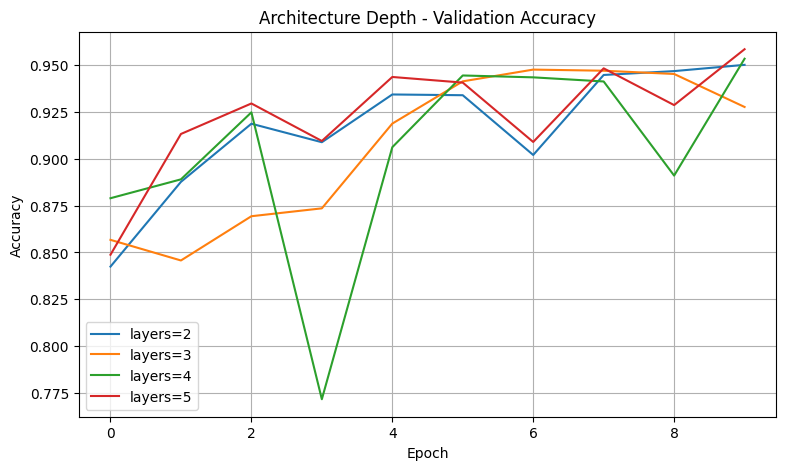

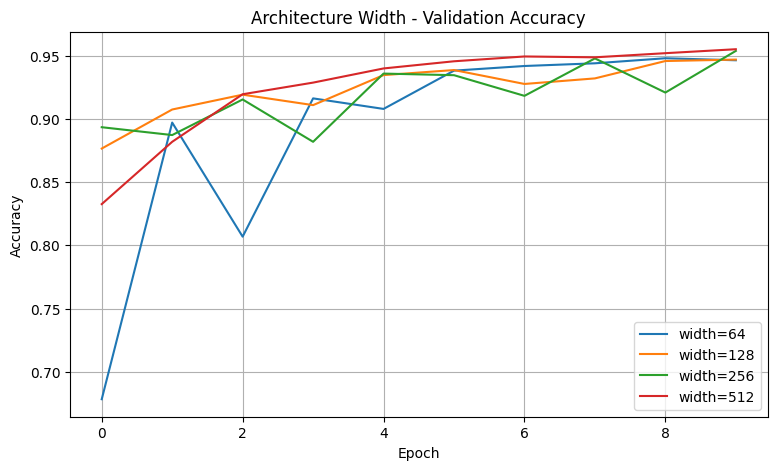

(   layers              hidden_layers  params  best_val_acc_%  time_sec
 3       5  [128, 128, 128, 128, 128]  167818           95.84    132.91
 2       4       [128, 128, 128, 128]  151306           95.33    125.71
 0       2                 [128, 128]  118282           95.01    120.83
 1       3            [128, 128, 128]  134794           94.75    121.98,
    width hidden_layers  params  best_val_acc_%  time_sec
 3    512    [512, 512]  669706           95.51    125.00
 2    256    [256, 256]  269322           95.37    123.74
 0     64      [64, 64]   55050           94.79    124.38
 1    128    [128, 128]  118282           94.69    124.94)

In [ ]:
# C1.c Architecture Analysis: depth and width
EPOCHS_SWEEP = 10
LR_BASE = 0.01
BS_BASE = 64

# Depth sweep (fixed width=128)
depths = [2, 3, 4, 5]
width_fixed = 128
arch_depth_results = []
for d in depths:
    hidden = [width_fixed] * d
    h = train_mlp_sweep(hidden_layers=hidden, lr=LR_BASE, batch_size=BS_BASE, epochs=EPOCHS_SWEEP)
    arch_depth_results.append(h)

# Width sweep (fixed depth=2)
widths = [64, 128, 256, 512]
arch_width_results = []
for w in widths:
    hidden = [w, w]
    h = train_mlp_sweep(hidden_layers=hidden, lr=LR_BASE, batch_size=BS_BASE, epochs=EPOCHS_SWEEP)
    arch_width_results.append(h)

# Depth plots
plot_metric_over_sweep(arch_depth_results, [f"layers={d}" for d in depths], 'val_accs', 'Architecture Depth - Validation Accuracy', 'Accuracy')

# Width plots
plot_metric_over_sweep(arch_width_results, [f"width={w}" for w in widths], 'val_accs', 'Architecture Width - Validation Accuracy', 'Accuracy')

# Summary tables with parameter counts
arch_depth_df = pd.DataFrame({
    'layers': depths,
    'hidden_layers': [str([width_fixed]*d) for d in depths],
    'params': [count_params(r['model']) for r in arch_depth_results],
    'best_val_acc_%': [round(r['best_val_acc']*100, 2) for r in arch_depth_results],
    'time_sec': [round(r['time_sec'], 2) for r in arch_depth_results]
}).sort_values('best_val_acc_%', ascending=False)

arch_width_df = pd.DataFrame({
    'width': widths,
    'hidden_layers': [str([w, w]) for w in widths],
    'params': [count_params(r['model']) for r in arch_width_results],
    'best_val_acc_%': [round(r['best_val_acc']*100, 2) for r in arch_width_results],
    'time_sec': [round(r['time_sec'], 2) for r in arch_width_results]
}).sort_values('best_val_acc_%', ascending=False)

arch_depth_df, arch_width_df


## C2. Model Comparison and Best Model Evaluation

We compare Logistic Regression (binary 0 vs 1), Softmax Regression (10-class), and the best NN from C1. We also present complexity estimates, training time, and a final confusion matrix with misclassified examples for the best model.


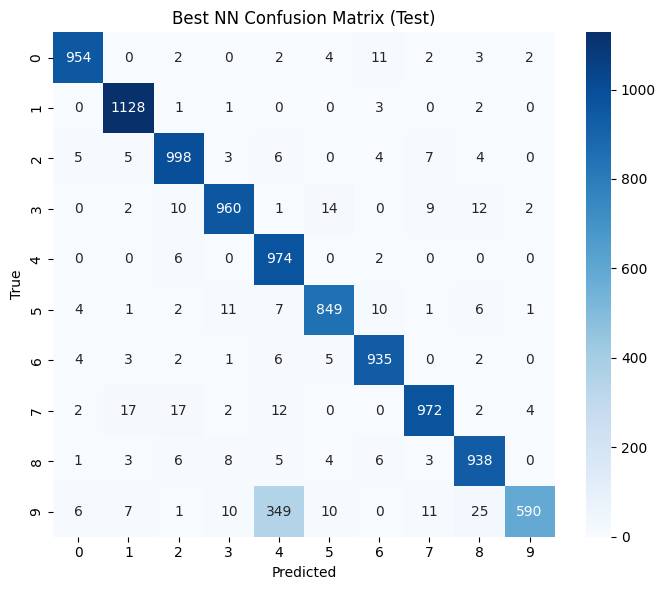

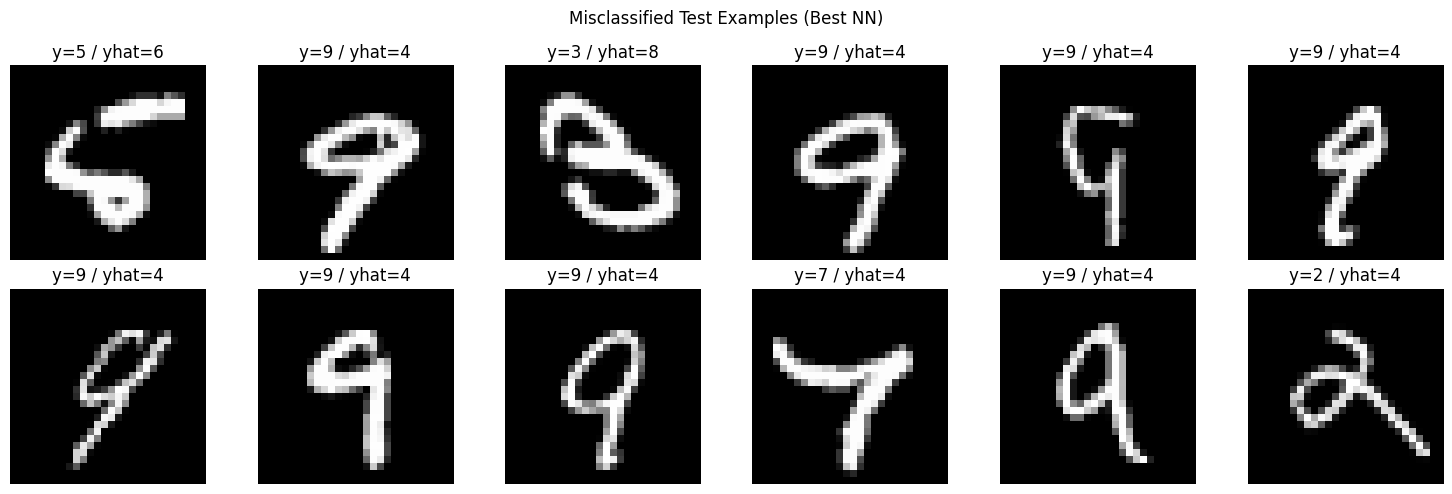

Epoch 10/30: TrainLoss=0.0082, ValLoss=0.0078, ValAcc=99.83%
Epoch 20/30: TrainLoss=0.0055, ValLoss=0.0058, ValAcc=99.86%
Epoch 30/30: TrainLoss=0.0046, ValLoss=0.0050, ValAcc=99.86%
Epoch 10/30: TrainLoss=0.3728, ValLoss=0.3778, ValAcc=89.70%
Epoch 20/30: TrainLoss=0.3293, ValLoss=0.3404, ValAcc=90.51%
Epoch 30/30: TrainLoss=0.3102, ValLoss=0.3252, ValAcc=90.94%


,model,params,train_time_sec,test_acc_%
0,Logistic (0 vs 1),785,44.11,99.83
1,Softmax (10-class),7850,41.39,90.94
2,"Best NN [128, 128, 128, 128, 128]",167818,193.21,92.98


In [ ]:
# C2 Comparison: Logistic vs Softmax vs Best NN
import time
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Pick best NN from C1 sweeps (depth + width); fallback to default [200, 50]
try:
    all_arch_results = []
    all_arch_results += arch_depth_results if 'arch_depth_results' in globals() else []
    all_arch_results += arch_width_results if 'arch_width_results' in globals() else []
    if len(all_arch_results) > 0:
        best_idx = int(np.argmax([r['best_val_acc'] for r in all_arch_results]))
        best_hidden = all_arch_results[best_idx]['hidden_layers']
    else:
        best_hidden = [200, 50]
except Exception:
    best_hidden = [200, 50]

# Train best NN (a bit longer) on Part B data
EPOCHS_BEST = 15
LR_BEST = 0.01
BS_BEST = 64
best_hist = train_mlp_sweep(hidden_layers=best_hidden, lr=LR_BEST, batch_size=BS_BEST, epochs=EPOCHS_BEST)
best_nn = best_hist['model']

# Evaluate best NN on Part B test set with confusion matrix
loaders_eval = get_loaders_bs(BS_BEST)
best_nn.eval()
correct, total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in loaders_eval['test']:
        xb = xb.to(device)
        logits = best_nn(xb)
        preds = logits.argmax(1).cpu()
        all_preds.append(preds)
        all_labels.append(yb)
        total += yb.size(0)
        correct += (preds == yb).sum().item()

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
best_nn_test_acc = 100.0 * (all_preds == all_labels).float().mean().item()
cm_best = confusion_matrix(all_labels.numpy(), all_preds.numpy())

plt.figure(figsize=(7,6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Best NN Confusion Matrix (Test)')
plt.tight_layout(); plt.show()

# Show some misclassified examples
mis_idx = (all_preds != all_labels).nonzero(as_tuple=False).squeeze()
if mis_idx.numel() > 0:
    n_show = min(12, mis_idx.numel())
    sample_idx = mis_idx[:n_show]
    imgs = []
    # fetch the corresponding images from test loader dataset
    for i in sample_idx:
        imgs.append(loaders_eval['test'].dataset[i][0].squeeze(0))
    cols = 6
    rows = int(np.ceil(n_show/cols))
    plt.figure(figsize=(2.5*cols, 2.5*rows))
    for j in range(n_show):
        plt.subplot(rows, cols, j+1)
        plt.imshow(imgs[j], cmap='gray')
        plt.title(f"y={all_labels[sample_idx[j]].item()} / yhat={all_preds[sample_idx[j]].item()}")
        plt.axis('off')
    plt.suptitle('Misclassified Test Examples (Best NN)')
    plt.tight_layout()
    plt.show()

# 2) Logistic and Softmax: reuse Part A implementations and timing on their splits
#    If Part A cells haven't run yet, these timings will error; run Part A first for accurate comparison.

comp_rows = []

# Logistic Regression (binary 0 vs 1)
try:
    t0 = time.time()
    lr_model_comp = LogisticRegressionFromScratch(784)
    _ = train_logistic_regression(lr_model_comp, train_loader, val_loader, LR_CLASSES, 0.01, 30, X_val, Y_val)
    t1 = time.time()
    lr_test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=BATCH_SIZE, shuffle=False)
    lr_test_acc = calculate_accuracy(lr_model_comp, lr_test_loader, True, LR_CLASSES)
    comp_rows.append({
        'model': 'Logistic (0 vs 1)',
        'params': 784*1 + 1,
        'train_time_sec': round(t1-t0, 2),
        'test_acc_%': round(lr_test_acc, 2)
    })
except Exception as e:
    comp_rows.append({
        'model': 'Logistic (0 vs 1)',
        'params': 784*1 + 1,
        'train_time_sec': None,
        'test_acc_%': None,
        'note': f'Run Part A first or ensure variables exist. ({e})'
    })

# Softmax Regression (10-class)
try:
    t0 = time.time()
    sm_model_comp = SoftmaxRegressionFromScratch(784, 10)
    _ = train_softmax_regression(sm_model_comp, train_loader, val_loader, 0.01, 30)
    t1 = time.time()
    sm_test_acc = calculate_accuracy(sm_model_comp, test_loader)
    comp_rows.append({
        'model': 'Softmax (10-class)',
        'params': 784*10 + 10,
        'train_time_sec': round(t1-t0, 2),
        'test_acc_%': round(sm_test_acc, 2)
    })
except Exception as e:
    comp_rows.append({
        'model': 'Softmax (10-class)',
        'params': 784*10 + 10,
        'train_time_sec': None,
        'test_acc_%': None,
        'note': f'Run Part A first or ensure variables exist. ({e})'
    })

# Best NN (from Part B data)
comp_rows.append({
    'model': f'Best NN {best_hidden}',
    'params': count_params(best_nn),
    'train_time_sec': round(best_hist['time_sec'], 2),
    'test_acc_%': round(best_nn_test_acc, 2)
})

comp_df = pd.DataFrame(comp_rows)
comp_df


## Part D: Advanced Techniques (Bonus)

In [ ]:
import time, copy, torch, torch.nn as nn, torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

#Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
LR = 0.01

# FNN Architecture for Comparison (Matches Part B minimum)
class SimpleFNN(nn.Module):
    def __init__(self, dropout_rate=0.0, use_batchnorm=False):
        super(SimpleFNN, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.fc1 = nn.Linear(784, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_batchnorm else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_batchnorm else nn.Identity()
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()

    def forward(self, x):
        # Flatten input from (B, 1, 28, 28) to (B, 784)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.0, use_batchnorm=False):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_batchnorm else None
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_batchnorm else None
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

    def forward(self, x):
        x = self.conv1(x)
        if self.bn1: x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        if self.bn2: x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        if self.dropout: x = self.dropout(x)
        return self.fc2(x)

# Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS, device=device):
    model = model.to(device)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total
        train_acc = (correct / total) * 100

        model.eval()
        v_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for vx, vy in val_loader:
                vx, vy = vx.to(device), vy.to(device)
                vout = model(vx)
                loss_v = criterion(vout, vy)
                v_loss += loss_v.item() * vx.size(0)
                _, vpred = torch.max(vout, 1)
                v_correct += (vpred == vy).sum().item()
                v_total += vy.size(0)

        val_loss = v_loss / v_total
        val_acc = (v_correct / v_total) * 100
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{epochs}: TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}, ValAcc={val_acc:.2f}%")

    model.load_state_dict(best_model_wts)
    return model, history

def evaluate_and_show(model, loader, title):
    model.eval()
    correct, total = 0, 0
    preds_all, labels_all = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            preds_all.append(pred.cpu().numpy())
            labels_all.append(y.cpu().numpy())

    acc = (correct / total) * 100
    cm = confusion_matrix(np.concatenate(labels_all), np.concatenate(preds_all))
    print(f"Test Accuracy for {title}: {acc:.2f}%")

    # Per-class accuracy analysis
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1) * 100
    print("Per-Class Accuracy (%):")
    print(np.round(per_class_accuracy, 2))

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {title}')
    plt.show()
    return acc

# Execution Logic
sample_x, _ = next(iter(train_loader))
if sample_x.ndim == 2 or sample_x.shape[1] == 784:
    # If data is flattened or just 2D, reshape it for CNN/FNN input
    print("Reshaping flat data loaders to 4D (B, 1, 28, 28) for NN/CNN...")
    train_loader = DataLoader(TensorDataset(train_loader.dataset.tensors[0].view(-1,1,28,28), train_loader.dataset.tensors[1]), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_loader.dataset.tensors[0].view(-1,1,28,28), val_loader.dataset.tensors[1]), batch_size=64, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_loader.dataset.tensors[0].view(-1,1,28,28), test_loader.dataset.tensors[1]), batch_size=64, shuffle=False)
elif sample_x.shape[1] != 1:
    print(f"Warning: Unexpected input shape {sample_x.shape}. Assuming (B, 1, 28, 28) needed.")

crit = nn.CrossEntropyLoss()

# D1. CNN vs Fully Connected Network Comparison
print("\n--- D1. CNN vs FNN Performance Comparison ---")

# 1. FNN Baseline (for comparison)
print("Training FNN Baseline...")
fnn = SimpleFNN()
opt_fnn = optim.SGD(fnn.parameters(), lr=LR)
fnn, hist_fnn = train_model(fnn, train_loader, val_loader, crit, opt_fnn, epochs=EPOCHS)
fnn_acc = evaluate_and_show(fnn, test_loader, "FNN Baseline")

# 2. Baseline CNN
print("\nTraining CNN Baseline...")
cnn = SimpleCNN()
opt_cnn = optim.SGD(cnn.parameters(), lr=LR)
cnn, hist_cnn = train_model(cnn, train_loader, val_loader, crit, opt_cnn, epochs=EPOCHS)
cnn_acc = evaluate_and_show(cnn, test_loader, "CNN Baseline")

print(f"\nAnalysis: CNN Accuracy ({cnn_acc:.2f}%) vs FNN Accuracy ({fnn_acc:.2f}%). The CNN should demonstrate the benefit of spatial feature learning, achieving a higher accuracy by using convolutional filters to extract edges and patterns.")

# --- D2. Regularization Techniques ---

# 1. Dropout Experiments
print("\n--- D2. Dropout Analysis ---")
drop_rates = [0.1, 0.3, 0.5, 0.7]
drop_accs = {}
for dr in drop_rates:
    print(f"\nTraining CNN with Dropout {dr}...")
    cnn_dr = SimpleCNN(dropout_rate=dr)
    opt = optim.SGD(cnn_dr.parameters(), lr=LR)
    cnn_dr, _ = train_model(cnn_dr, train_loader, val_loader, crit, opt, epochs=EPOCHS)
    drop_accs[dr] = evaluate_and_show(cnn_dr, test_loader, f"CNN Dropout {dr}")

# 2. BatchNorm and Combined Effect
print("\n--- D2. Batch Normalization and Combined Effect ---")

# BatchNorm Only
print("Training CNN with BatchNorm ONLY...")
cnn_bn = SimpleCNN(use_batchnorm=True)
opt_bn = optim.SGD(cnn_bn.parameters(), lr=LR)
cnn_bn, hist_bn = train_model(cnn_bn, train_loader, val_loader, crit, opt_bn, epochs=EPOCHS)
bn_acc = evaluate_and_show(cnn_bn, test_loader, "CNN BatchNorm")

# BatchNorm + Dropout (e.g., 0.5) - REQUIRED EXPERIMENT
print("\nTraining CNN with BatchNorm + Dropout 0.5 (Combined Effect)...")
cnn_combined = SimpleCNN(dropout_rate=0.5, use_batchnorm=True)
opt_combined = optim.SGD(cnn_combined.parameters(), lr=LR)
cnn_combined, hist_combined = train_model(cnn_combined, train_loader, val_loader, crit, opt_combined, epochs=EPOCHS)
combined_acc = evaluate_and_show(cnn_combined, test_loader, "CNN BN + Dropout 0.5")

print("\n--- Final Summary of Bonus Results ---")
print(f"FNN Baseline Accuracy: {fnn_acc:.2f}%")
print(f"CNN Baseline Accuracy: {cnn_acc:.2f}%")
print("--- Dropout Analysis ---")
for dr, acc in drop_accs.items():
    print(f"Dropout {dr} Accuracy: {acc:.2f}%")
print("--- Batch Norm Analysis ---")
print(f"BatchNorm ONLY Accuracy: {bn_acc:.2f}%")
print(f"BN + Dropout 0.5 Accuracy (Combined Effect): {combined_acc:.2f}%")